In [1]:
import Functions as f   
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import random


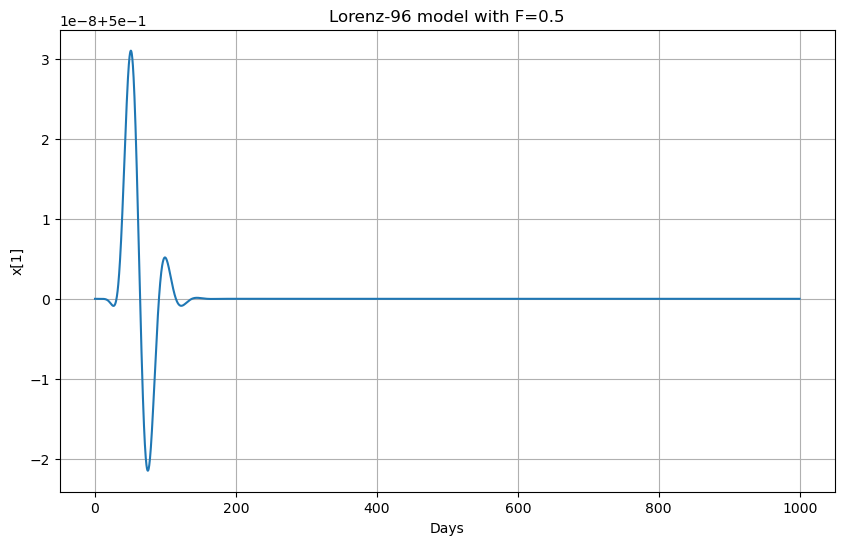

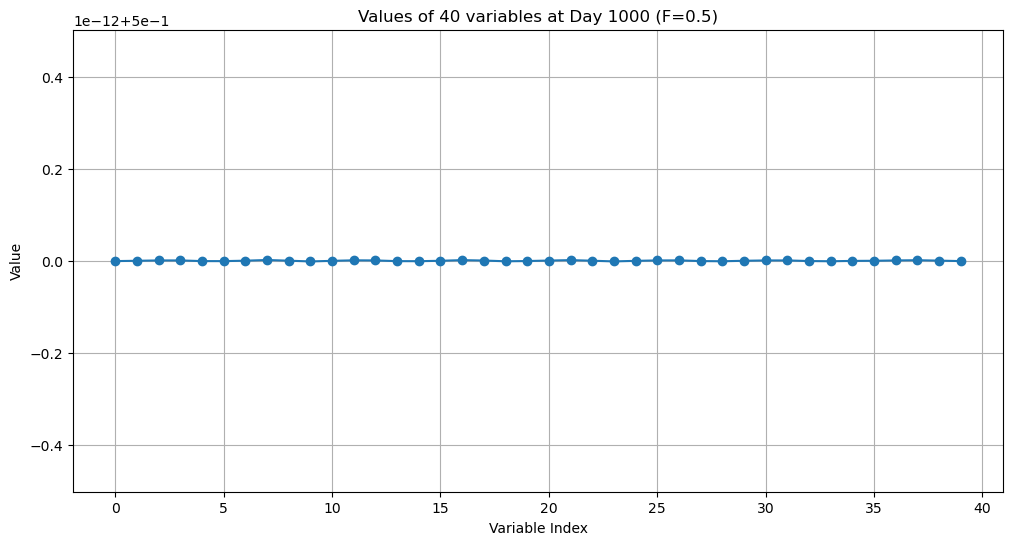

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


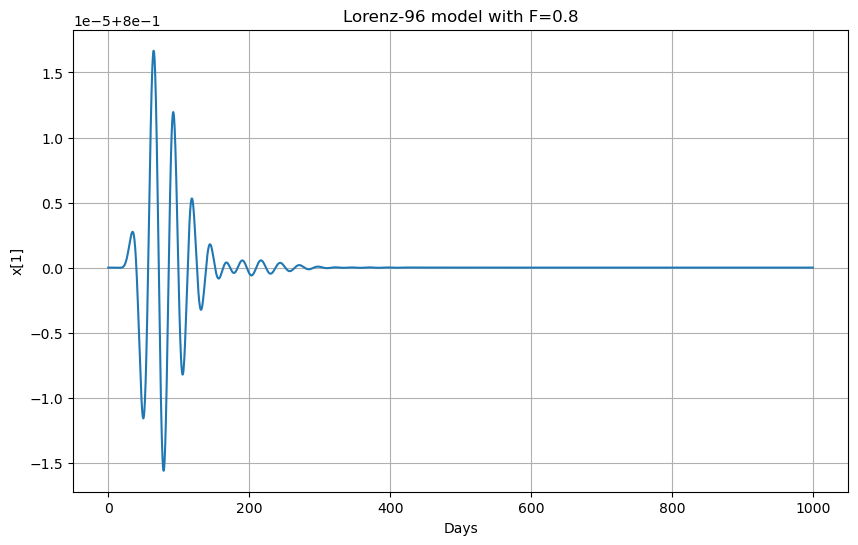

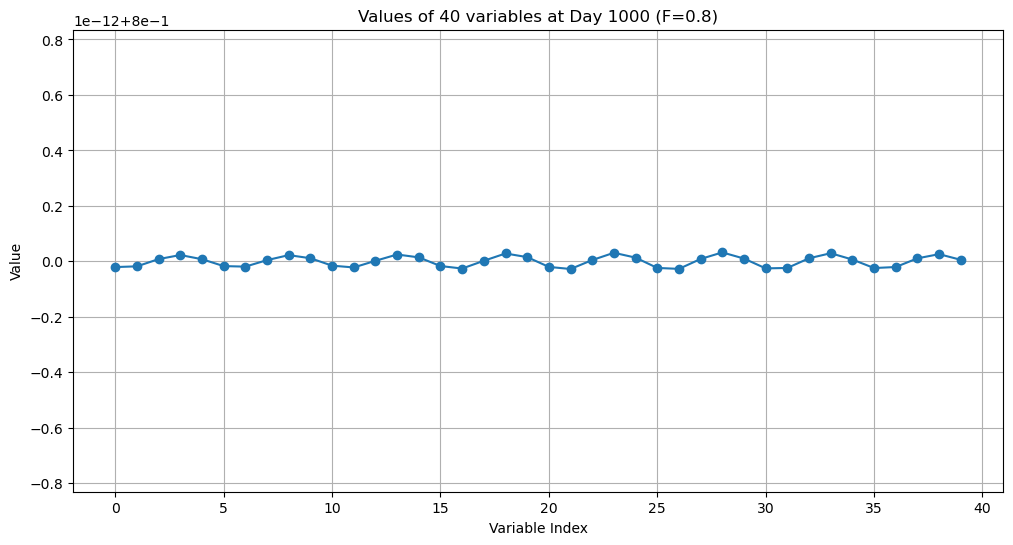

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


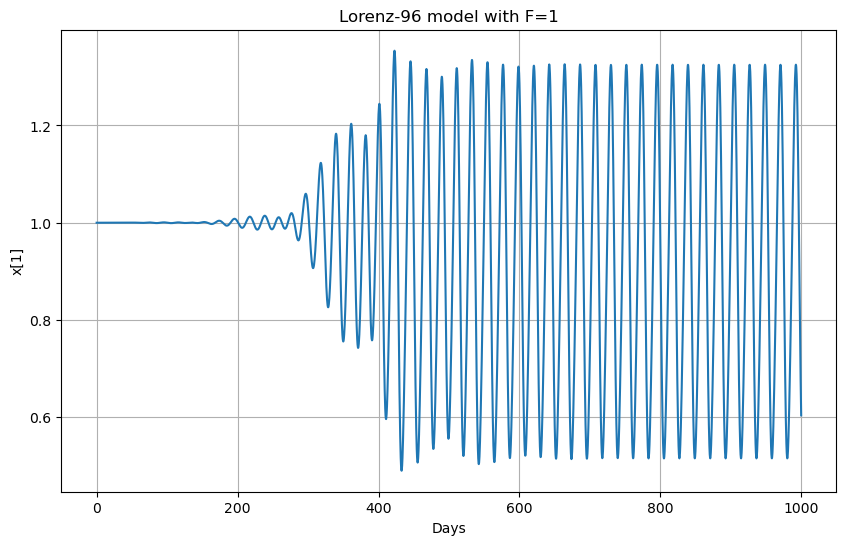

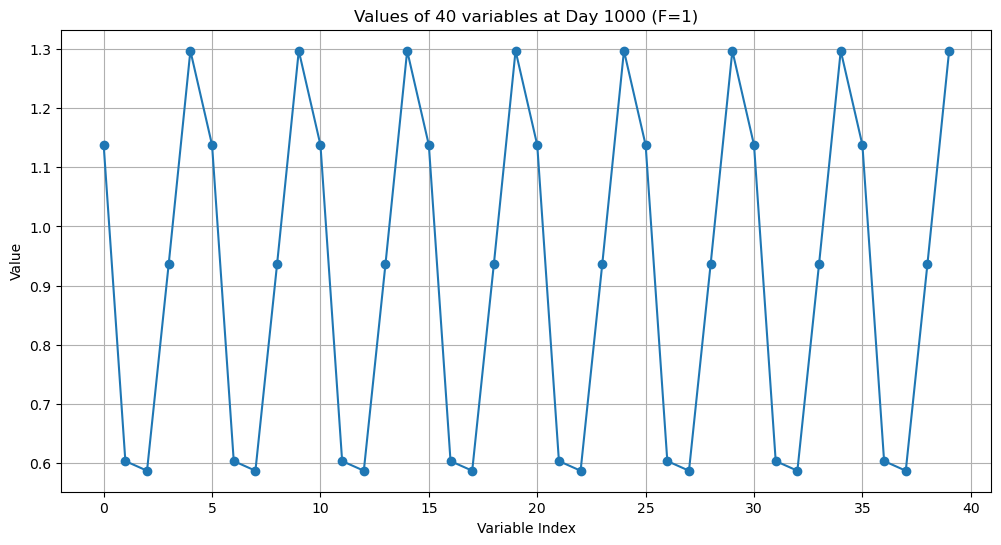

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


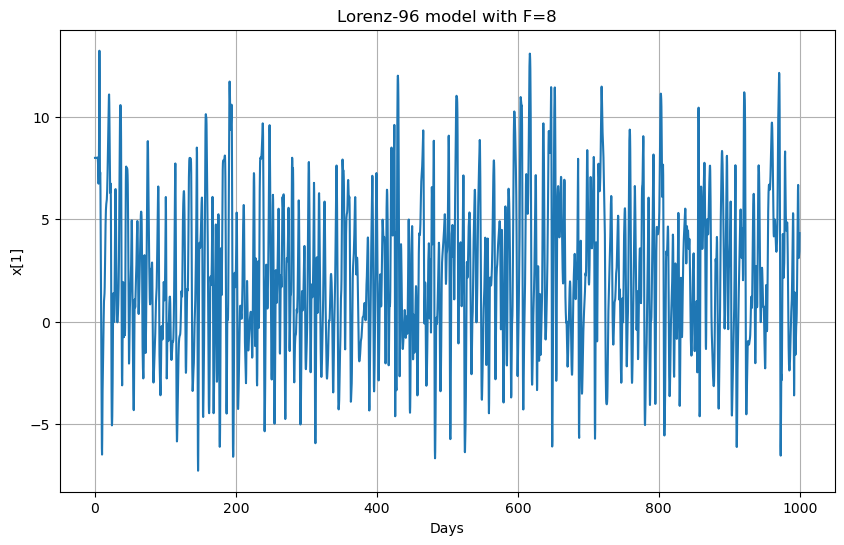

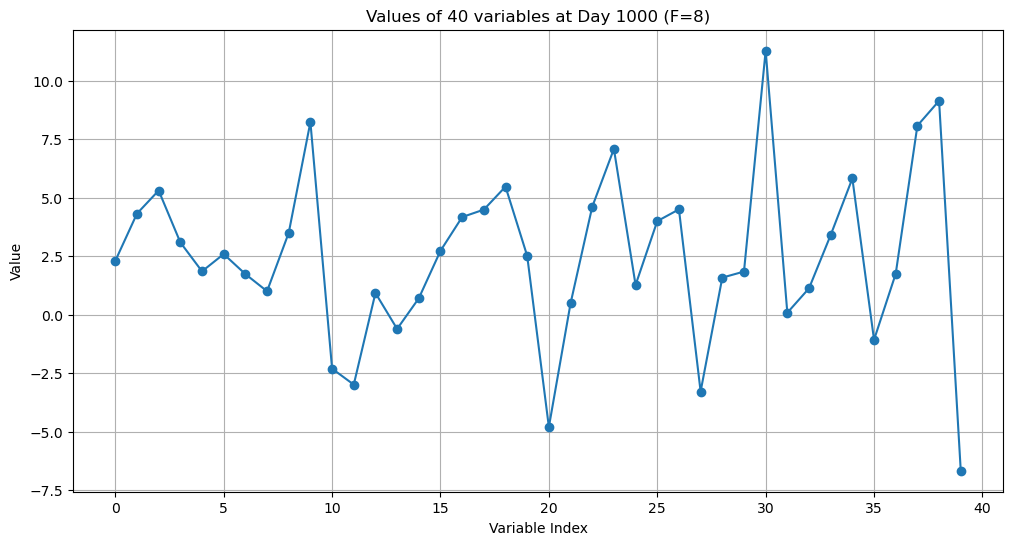

[0.0000e+00 2.5000e-01 5.0000e-01 ... 9.9925e+02 9.9950e+02 9.9975e+02]


In [2]:
"""
１．Lorenz-96 を 4 次の Runge-Kutta 法を用いて実装する。パラメータ値 F をいろいろ変え、
F=8 でカオスとなることを確認する。余裕があれば、他の時間積分スキームも実装してみる。
"""

# Parameters
N = 40  # Number of variables
F_values = [0.5,0.8,1,8]  # Different values of F to test
dt = 0.05  # A time step equivalent to 6 hours
Days = 1000  # Total days
steps = Days * 4   # Number of steps

# Time integration
for F in F_values:
    # Initial condition
    x0 = F * np.ones(N)
    x0[N // 2 - 1] *= 1.001  # Add small perturbation to break symmetry
    x = np.copy(x0)
    trajectory = np.zeros((steps, N))
    for t in range(steps):
        x = f.rk4_step(x, dt, F)
        trajectory[t] = x

    # Plot results with 4 steps as 1 day
    plt.figure(figsize=(10, 6))
    days = np.arange(steps) / 4  # Convert time steps to days (4 steps = 1 day)
    plt.plot(days, trajectory[:, 1])  # Use days on the x-axis
    plt.title(f'Lorenz-96 model with F={F}')
    plt.xlabel('Days')
    plt.ylabel('x[1]')
    plt.grid()
    plt.show()

    # Plot the values of the 40 variables at Day 1000
    day_index = Days * 4  # Convert day to time step (4 time steps per day)
    plt.figure(figsize=(12, 6))
    plt.plot(range(N), trajectory[day_index - 1], marker='o')
    plt.title(f'Values of 40 variables at Day {Days} (F={F})')
    plt.xlabel('Variable Index')
    plt.ylabel('Value')
    plt.grid()
    plt.show()
    print(days)

Average initial RMSE = 0.000050
Average RMSE doubled on Day 1.75.


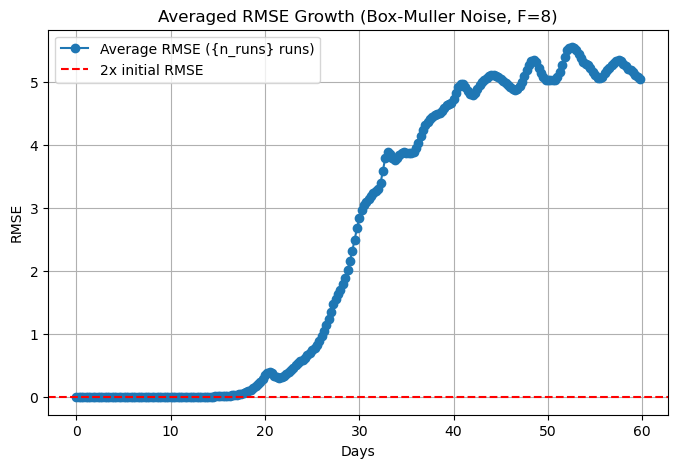

In [3]:
""" 
2. パラメータ値 F=8 とする。誤差の平均発達率について調べ、0.2 時間ステップを 1 日と定義することの妥当性を確認する。
"""
# Set parameters
N = 40
F = 8
dt = 0.05           # 0.2 time units = 1 day
days = 60
steps = days * 4    # 1 step = 1 day in this setup
spinup_days = 365
spinup_steps = spinup_days * 4  # Spin-up time in steps

# Reference initial condition (noise-free)
x_ref = np.sin(np.arange(N) * 2 * np.pi / N) + F * np.ones(N)
# x_ref = F * np.ones(N)
# Spin up the reference trajectory
for t in range(spinup_steps):
    x_ref = f.rk4_step(x_ref, dt, F)
# Multi-run averaging
noise_scale = 0.00005
n_runs = 1000
avg_rmse_vals = np.zeros(steps)

for run in range(n_runs):
    # Create a new noisy initial condition for each run
    x_noisy_run = np.copy(x_ref)
    for i in range(N):
        x_noisy_run[i] += f.box_muller(0.0, noise_scale)
    
    # Allocate storage for single-run trajectories
    traj_ref_run = np.zeros((steps, N))
    traj_noisy_run = np.zeros((steps, N))
    rmse_vals_run = np.zeros(steps)

    # Initial states for this run
    traj_ref_run[0] = x_ref
    traj_noisy_run[0] = x_noisy_run
    rmse_vals_run[0] = f.rmse(x_ref, x_noisy_run)
    
    # Time integration for this run
    for t in range(1, steps):
        traj_ref_run[t] = f.rk4_step(traj_ref_run[t - 1], dt, F)
        traj_noisy_run[t] = f.rk4_step(traj_noisy_run[t - 1], dt, F)
        rmse_vals_run[t] = f.rmse(traj_ref_run[t], traj_noisy_run[t])
    
    # Accumulate for averaging
    avg_rmse_vals += rmse_vals_run

# Final average over all runs
avg_rmse_vals /= n_runs

# Determine when average RMSE doubles
initial_err = avg_rmse_vals[0]
threshold = 2.0 * initial_err
doubling_day = None
for step in range(1, steps):
    if avg_rmse_vals[step] >= threshold:
        doubling_day = step / 4.0  # 4 steps = 1 day
        break

print(f"Average initial RMSE = {initial_err:.6f}")
if doubling_day is not None:
    print(f"Average RMSE doubled on Day {doubling_day}.")
else:
    print("Average RMSE did not double within this period.")

# Plot averaged RMSE evolution
plt.figure(figsize=(8,5))
days_axis = np.arange(steps) / 4.0
plt.plot(days_axis, avg_rmse_vals, marker='o', label='Average RMSE ({n_runs} runs)')
plt.axhline(threshold, color='r', linestyle='--', label='2x initial RMSE')
plt.title("Averaged RMSE Growth (Box-Muller Noise, F=8)")
plt.xlabel("Days")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
"""
３．2 年分積分し、最初の 1 年分をスピンアップとして捨てる。後半 1 年分を 6 時間毎に保存しておく。
"""
N = 40
F = 8
spinup_days = 365
data_days = 365
total_days = spinup_days + data_days  # 2 years total
dt = 0.05  # 6 hours per step
steps_per_day = 4
spinup_steps = spinup_days * steps_per_day
total_steps = total_days * steps_per_day

# Initial condition
x0 = F * np.ones(N)
x0[N // 2 - 1] *= 1.001
trajectory = np.zeros((total_steps, N))
x = x0.copy()

# Integrate for 2 years
for t in range(total_steps):
    x = f.rk4_step(x, dt, F)
    trajectory[t] = x

# Discard first year (spin-up), keep second year data
stored_data = trajectory[spinup_steps:].copy()  # shape = (data_days*steps_per_day, N)


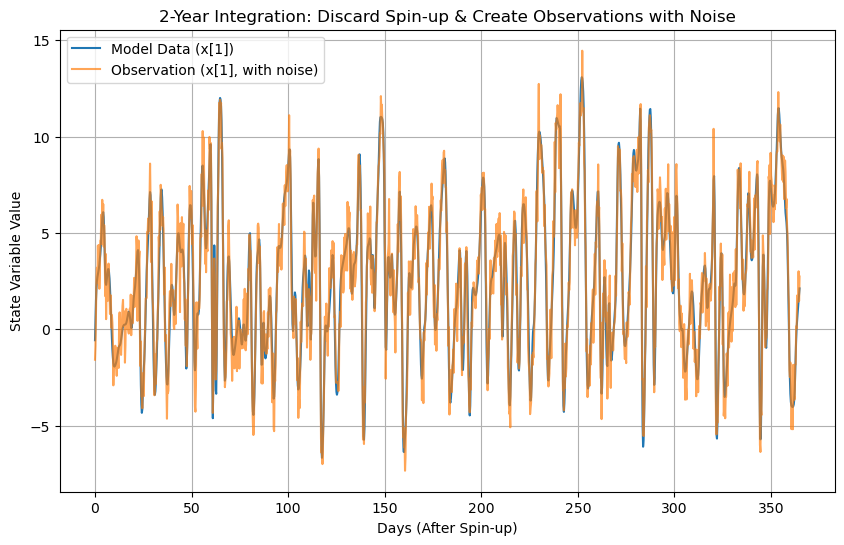

In [5]:
"""
４． Mersenne Twister 等の性質の良い乱数生成プログラムを用いて分散 1 の正規分布乱数を生成し、３で保存した 6 時間毎の場に足しこんで、別途保存する。これを観測データとする。
"""
obs_data = stored_data.copy()
for t in range(obs_data.shape[0]):
    for i in range(N):
        obs_data[t, i] += random.gauss(0.0, 1.0)

# Then you can save both stored_data and obs_data if desired:
# np.save("stored_data.npy", stored_data)
# np.save("obs_data.npy", obs_data)

plt.figure(figsize=(10, 6))
days_axis = np.arange(stored_data.shape[0]) / steps_per_day
plt.plot(days_axis, stored_data[:, 1], label="Model Data (x[1])")
plt.plot(days_axis, obs_data[:, 1], label="Observation (x[1], with noise)", alpha=0.7)
plt.xlabel("Days (After Spin-up)")
plt.ylabel("State Variable Value")
plt.title("2-Year Integration: Discard Spin-up & Create Observations with Noise")
plt.legend()
plt.grid(True)
plt.show()

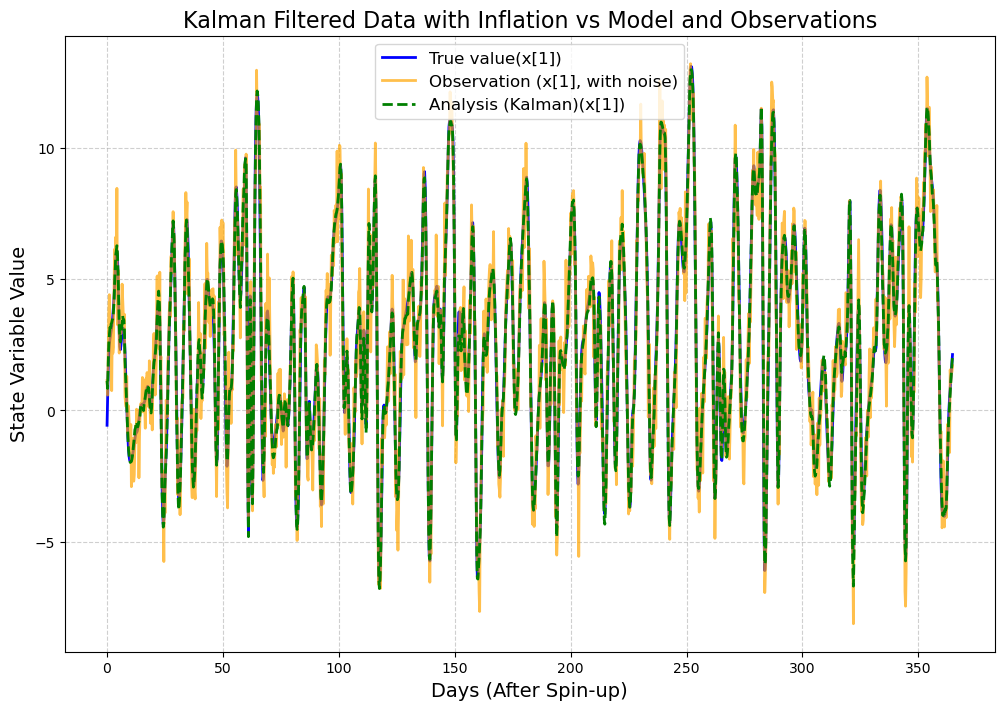

In [11]:
"""
５．6 時間サイクルのデータ同化システムを構築する。KF の式を直接解くものでよい。ただし、
KF の予報誤差共分散の部分に定数を入れられるように設計しておく。（定数を入れると、3 次元
変分法と同値である）
"""

# Kalman Filter parameters
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance (identity for simplicity)
Q = np.eye(N) * 0  # Process noise covariance (small value)
P = np.eye(N) * 10  # Initial state covariance (uncertainty in initial state)
x = stored_data[0,:]  # Initial state estimate (zero for simplicity)
alpha = 0.05  # Inflation factor

# Storage for filtered data
filtered_data = np.zeros_like(obs_data)  # Shape: (data_days*steps_per_day, N)

# Kalman Filter loop
for t in range(obs_data.shape[0]):
    # Update the Kalman Filter with the observation
    x, P = f.kalman_filter(x, P, H, R, obs_data[t], Q,f.rk4_step,alpha=0.09)
    filtered_data[t] = x  # Store the filtered state

# Plotting the results with improved visibility
plt.figure(figsize=(12, 8))
days_axis = np.arange(obs_data.shape[0]) / steps_per_day
plt.plot(days_axis, stored_data[:, 1], label="True value(x[1])", linewidth=2, color='blue')
plt.plot(days_axis, obs_data[:, 1], label="Observation (x[1], with noise)", linewidth=2, color='orange', alpha=0.7)
plt.plot(days_axis, filtered_data[:, 1], label="Analysis (Kalman)(x[1])", linestyle='--', linewidth=2, color='green')
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("State Variable Value", fontsize=14)
plt.title("Kalman Filtered Data with Inflation vs Model and Observations", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

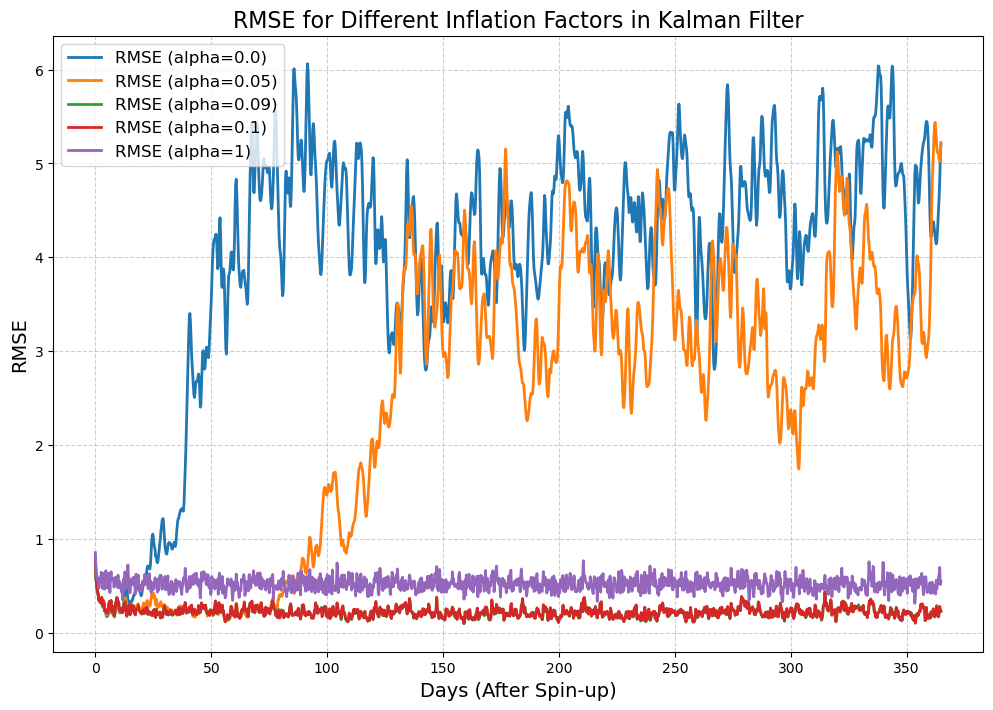

In [12]:
#Evaluate KF performance for different inflation factors
alphas = [0.0, 0.05,0.09 , 0.1,1]  # List of inflation factors to test
rmse_results = []

for alpha in alphas:
    x = stored_data[0, :]  # Reset initial state estimate
    P = np.eye(N) * 10  # Reset initial covariance matrix
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])  # Store RMSE values for this alpha

    # Kalman Filter loop
    for t in range(obs_data.shape[0]):
        x, P = f.kalman_filter(x, P, H, R, obs_data[t], Q, f.rk4_step, alpha)
        filtered_data[t] = x
        rmse_value = f.rmse(stored_data[t], filtered_data[t])
        rmse_values[t] = rmse_value  # Store RMSE for this time step)

    # Compute RMSE for this alpha
    rmse_results.append(rmse_values)

# Plot RMSE vs alpha
plt.figure(figsize=(12, 8))
for i, alpha in enumerate(alphas):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results[i], label=f"RMSE (alpha={alpha})", linewidth=2)
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE for Different Inflation Factors in Kalman Filter", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [2]:
"""
７． EnKF を実装し、 KF との比較実験を行う。 
"""

'\n７． EnKF を実装し、 KF との比較実験を行う。 \n'

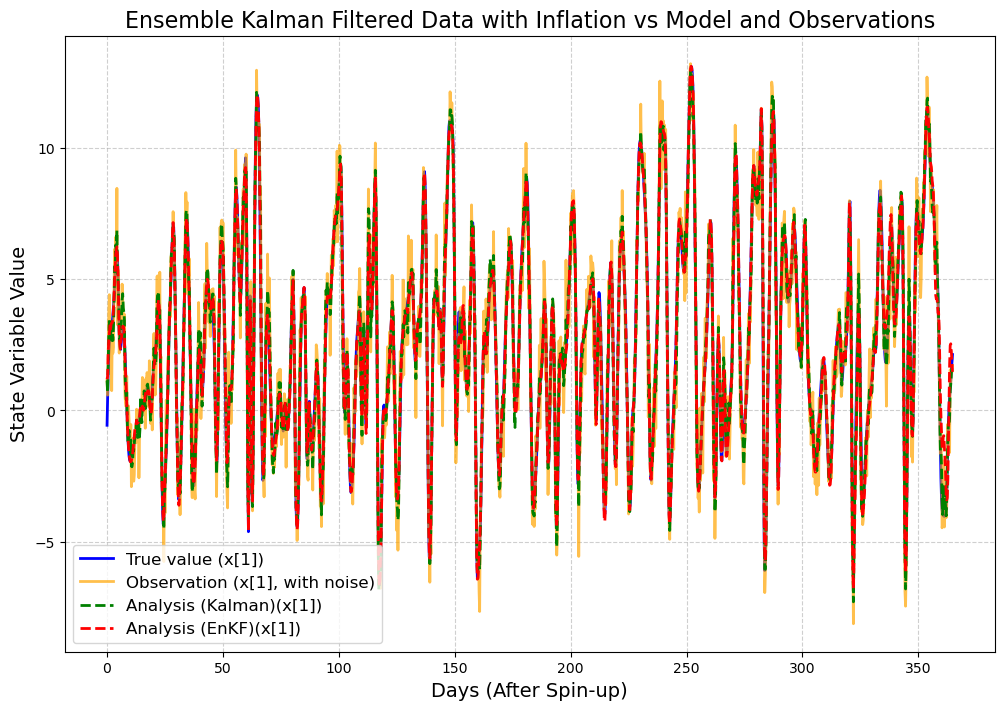

In [ ]:

# Ensemble Kalman Filter parameters
ensemble_size = 100  

P = np.eye(N) * 1   # Initial state covariance 
x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T # Initial ensemble members 　
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance 
Q = np.eye(N) * 0  # Process noise covariance 
alpha = 0.5  # Inflation factor
# Storage for filtered data     
filtered_data_enkf = np.zeros_like(obs_data)  # Shape: (data_days*steps_per_day, N)

# Kalman Filter loop
for t in range(obs_data.shape[0]):
    x = f.ensemble_kalman_filter(x, H, R, obs_data[t], Q, f.rk4_step, alpha)
    filtered_data_enkf[t] = np.mean(x, axis=1)
# Plotting the results with improved visibility
plt.figure(figsize=(12, 8))
days_axis = np.arange(obs_data.shape[0]) / steps_per_day    
plt.plot(days_axis, stored_data[:, 1], label="True value (x[1])", linewidth=2, color='blue')
plt.plot(days_axis, obs_data[:, 1], label="Observation (x[1], with noise)", linewidth=2, color='orange', alpha=0.7)
plt.plot(days_axis, filtered_data[:, 1], label="Analysis (Kalman)(x[1])", linestyle='--', linewidth=2, color='green')
plt.plot(days_axis, filtered_data_enkf[:, 1], label="Analysis (EnKF)(x[1])", linestyle='--', linewidth=2, color='red')
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("State Variable Value", fontsize=14)
plt.title("Ensemble Kalman Filtered Data with Inflation vs Model and Observations", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



Running EnKF with ensemble size 20
Running EnKF with ensemble size 50
Running EnKF with ensemble size 100
Running EnKF with ensemble size 200
Running EnKF with ensemble size 500


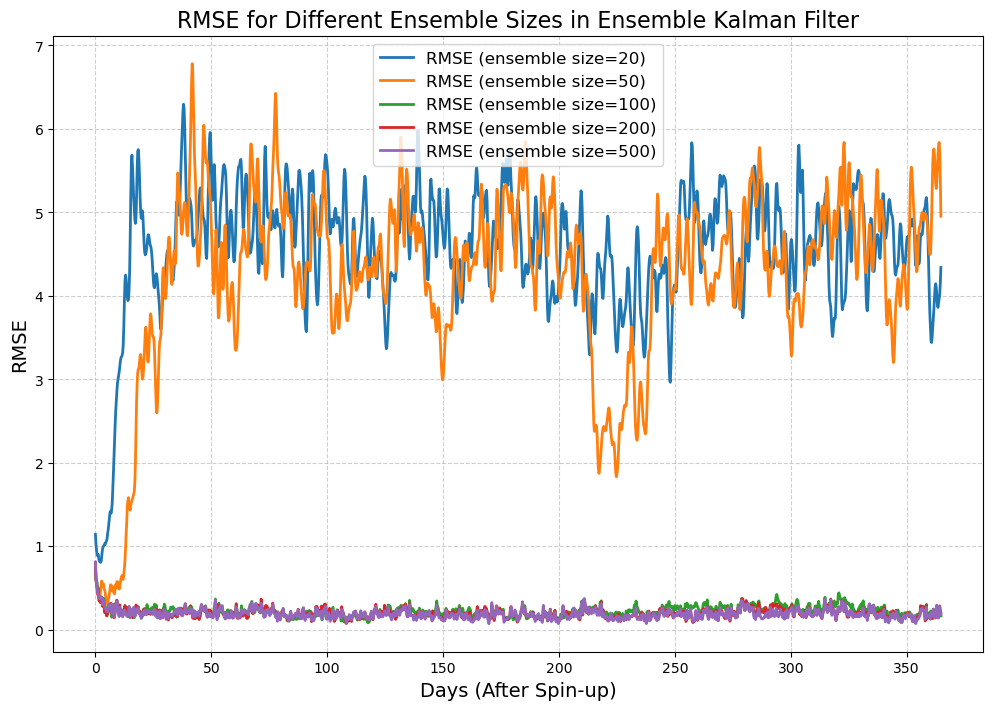

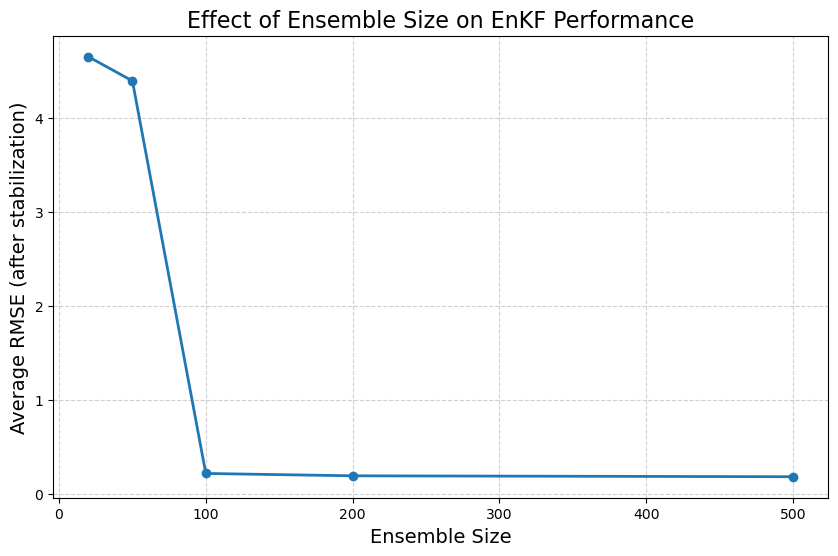

In [14]:
# Compare EnKF performance for different ensemble sizes
ensemble_sizes = [20, 50, 100, 200, 500]  # List of ensemble sizes to test
# ensemble_sizes = [20, 50]  # List of ensemble sizes to test
rmse_results_enkf = []

for ens_size in ensemble_sizes:
    print(f"Running EnKF with ensemble size {ens_size}")
    
    # Reset initial ensemble
    P = np.eye(N) * 10  # Initial state covariance
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T  # Initial ensemble members
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])  # Store RMSE values for this ensemble size
    
    # EnKF loop
    for t in range(obs_data.shape[0]):
        x = f.ensemble_kalman_filter(x, H, R, obs_data[t], Q, f.rk4_step, alpha)
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    # Compute RMSE for this ensemble size
    rmse_results_enkf.append(rmse_values)

# Plot RMSE vs ensemble size
plt.figure(figsize=(12, 8))
for i, ens_size in enumerate(ensemble_sizes):
    days_axis = np.arange(obs_data.shape[0]) / steps_per_day
    plt.plot(days_axis, rmse_results_enkf[i], label=f"RMSE (ensemble size={ens_size})", linewidth=2)

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("RMSE for Different Ensemble Sizes in Ensemble Kalman Filter", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization (e.g., after day 50)
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_enkf]

plt.figure(figsize=(10, 6))
plt.plot(ensemble_sizes, avg_rmse_by_size, 'o-', linewidth=2)
plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title("Effect of Ensemble Size on EnKF Performance", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Testing EnKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200
Testing ETKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200


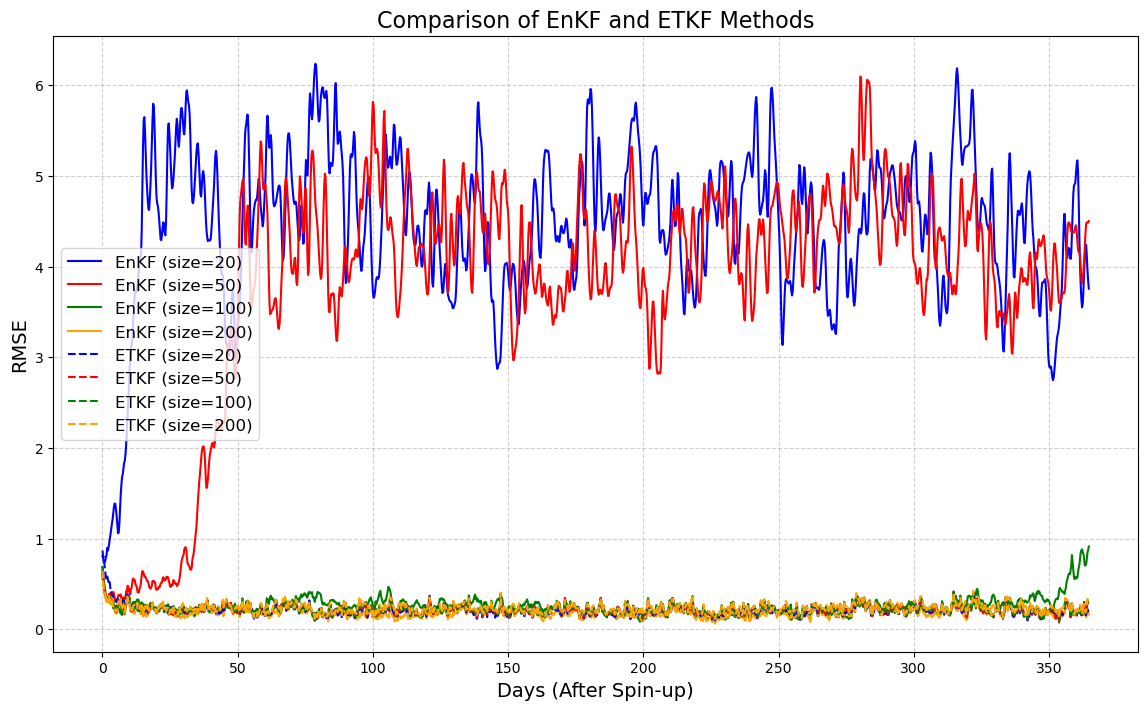

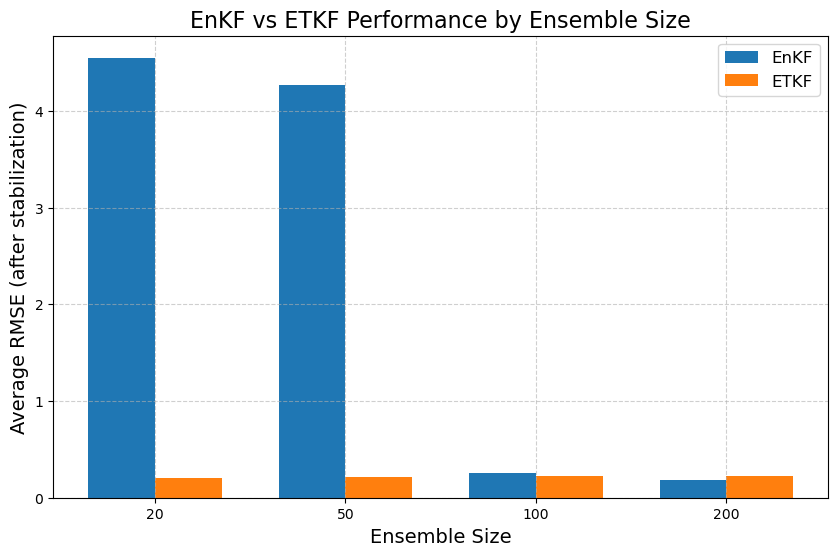

In [ ]:
"""
8． ETKF を実装し、 ETKF との比較実験を行う。 
"""
# Compare EnKF and ETKF performance
ensemble_sizes = [20, 50, 100,200]  # List of ensemble sizes to test
methods = ["EnKF", "ETKF"]
rmse_results_all = []


H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance 
Q = np.eye(N) * 0  # Process noise covariance 

for method in methods:
    print(f"Testing {method} method...")
    rmse_results_method = []
    
    for ens_size in ensemble_sizes:
        print(f"Running with ensemble size {ens_size}")
        
        # Reset initial ensemble
        P = np.eye(N) * 1
        x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T
        
        filtered_data = np.zeros_like(obs_data)
        rmse_values = np.zeros(obs_data.shape[0])
        
        # Filter loop
        for t in range(obs_data.shape[0]):
            if method == "EnKF":
                x = f.ensemble_kalman_filter(x, H, R, obs_data[t], Q, f.rk4_step, alpha=0.09)
            else:  # ETKF
                x = f.ensemble_transform_kalman_filter(x, H, R, obs_data[t], Q, f.rk4_step, alpha=0.09)
            
            filtered_data[t] = np.mean(x, axis=1)
            rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
        
        rmse_results_method.append(rmse_values)
    
    rmse_results_all.append(rmse_results_method)

# Plot comparison of methods
plt.figure(figsize=(14, 8))
linestyles = ['-', '--']
colors = ['blue', 'red', 'green', 'orange']

for i, method in enumerate(methods):
    for j, ens_size in enumerate(ensemble_sizes):
        days_axis = np.arange(obs_data.shape[0]) / steps_per_day
        plt.plot(days_axis, rmse_results_all[i][j], 
                 label=f"{method} (size={ens_size})", 
                 linestyle=linestyles[i], 
                 color=colors[j])

plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Comparison of EnKF and ETKF Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_method = []

for i, method in enumerate(methods):
    avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_all[i]]
    avg_rmse_by_method.append(avg_rmse_by_size)

# Bar plot for average RMSE comparison
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(ensemble_sizes))

for i, method in enumerate(methods):
    plt.bar(x + i*width, avg_rmse_by_method[i], width, label=method)

plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title("EnKF vs ETKF Performance by Ensemble Size", fontsize=16)
plt.xticks(x + width/2, ensemble_sizes)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Testing ENKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200
Testing LETKF method...
Running with ensemble size 20
Running with ensemble size 50
Running with ensemble size 100
Running with ensemble size 200


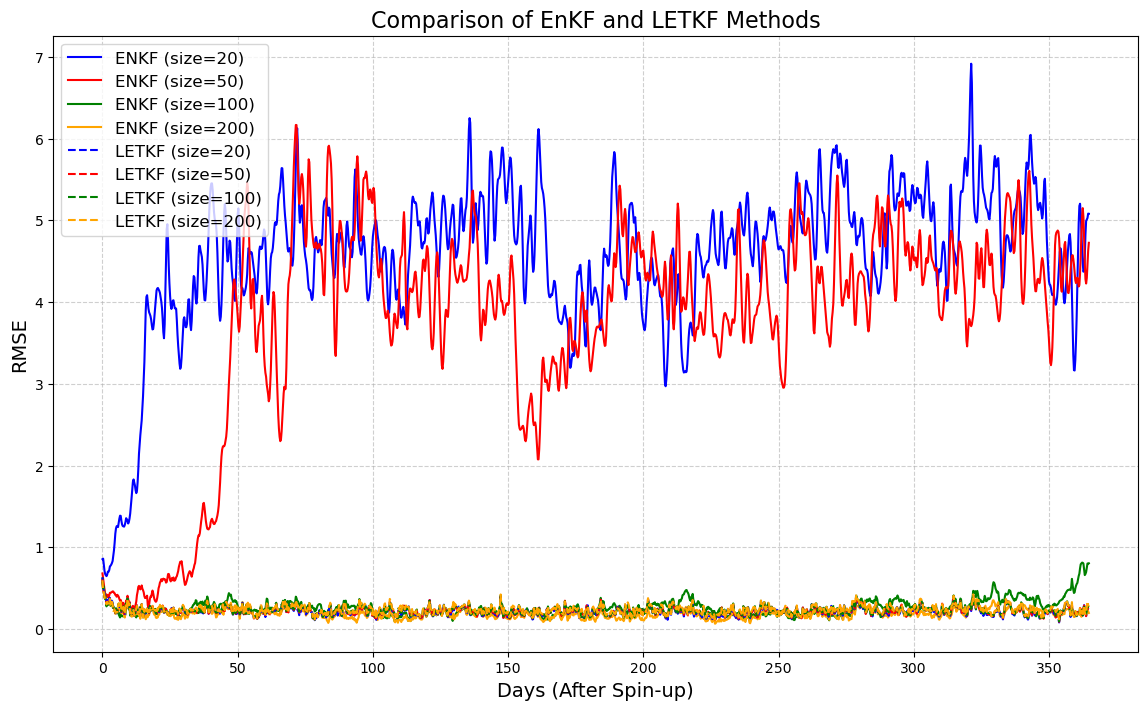

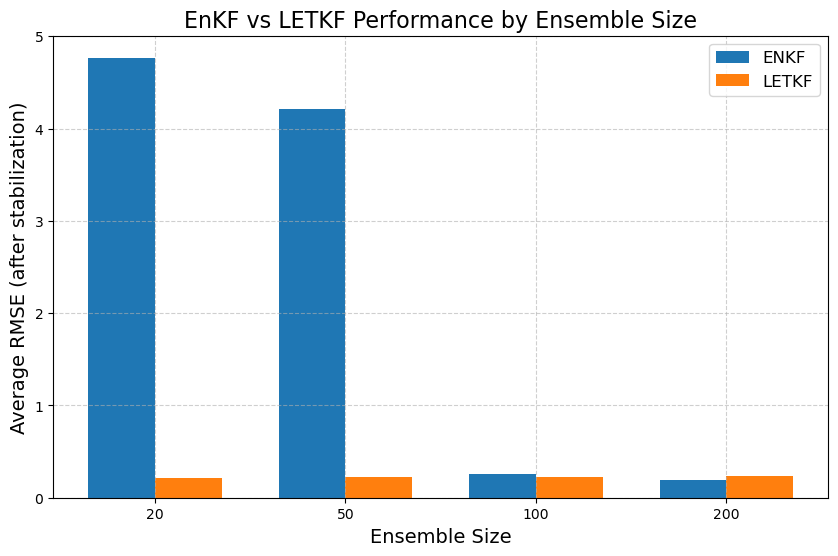

In [ ]:
"""
9． LETKF を実装し、 ETKF との比較実験を行う。 
"""
# Compare LETKF performance
ensemble_sizes = [20, 50, 100, 200]  # List of ensemble sizes to test
methods = ["ENKF","LETKF"]
rmse_results_all = []
H = np.eye(N)  # Observation matrix (identity for direct observation)
R = np.eye(N)  # Observation noise covariance
Q = np.eye(N) * 0  # Process noise covariance           

for method in methods:      
    print(f"Testing {method} method...")
    rmse_results_method = []
    
    for ens_size in ensemble_sizes:
        print(f"Running with ensemble size {ens_size}")
        
        # Reset initial ensemble
        P = np.eye(N) * 1
        x = np.random.multivariate_normal(stored_data[0,:], P, size=ens_size).T
        
        filtered_data = np.zeros_like(obs_data)
        rmse_values = np.zeros(obs_data.shape[0])
        
        # Filter loop
        for t in range(obs_data.shape[0]):
            if method == "ENKF":
                x = f.ensemble_kalman_filter(x, H, R, obs_data[t], Q, f.rk4_step, alpha=0.09)
            else:  # LETKF
                x = f.local_ensemble_transform_kalman_filter(x, H, R, obs_data[t], Q, loc_radius=5, model=f.rk4_step, alpha=0.09)
            
            filtered_data[t] = np.mean(x, axis=1)
            rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
        
        rmse_results_method.append(rmse_values)
    
    rmse_results_all.append(rmse_results_method)

    
# Plot comparison of methods
plt.figure(figsize=(14, 8))
linestyles = ['-', '--']
colors = ['blue', 'red', 'green', 'orange'] 
for i, method in enumerate(methods):
    for j, ens_size in enumerate(ensemble_sizes):
        days_axis = np.arange(obs_data.shape[0]) / steps_per_day
        plt.plot(days_axis, rmse_results_all[i][j], 
                 label=f"{method} (size={ens_size})", 
                 linestyle=linestyles[i], 
                 color=colors[j])
plt.xlabel("Days (After Spin-up)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Comparison of EnKF and LETKF Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Compare average RMSE after stabilization
stabilized_day = 50
stabilized_index = stabilized_day * steps_per_day
avg_rmse_by_method = []
for i, method in enumerate(methods):
    avg_rmse_by_size = [np.mean(rmse_vals[stabilized_index:]) for rmse_vals in rmse_results_all[i]]
    avg_rmse_by_method.append(avg_rmse_by_size)


# Bar plot for average RMSE comparison
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(ensemble_sizes))
for i, method in enumerate(methods):
    plt.bar(x + i*width, avg_rmse_by_method[i], width, label=method)
plt.xlabel("Ensemble Size", fontsize=14)
plt.ylabel("Average RMSE (after stabilization)", fontsize=14)
plt.title("EnKF vs LETKF Performance by Ensemble Size", fontsize=16)
plt.xticks(x + width/2, ensemble_sizes)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [5]:
"""
10． LPF, LPFGM を実装し、 パラメータ調整を行う。 
"""

'\n10． LPF, LPFGM を実装し、 パラメータ調整を行う。 \n'

Testing LPFGM with different gamma values (alpha=0.8, radius=0.5)...
Running LPFGM with gamma=0.1
Running LPFGM with gamma=0.2
Running LPFGM with gamma=0.3
Running LPFGM with gamma=0.4
Running LPFGM with gamma=0.5
Running LPFGM with gamma=1.5
Running LPFGM with gamma=2.5
Running LPFGM with gamma=3.5
Running LPFGM with gamma=4
Running LPFGM with gamma=4.5
Running LPFGM with gamma=5
Running LPFGM with gamma=5.5


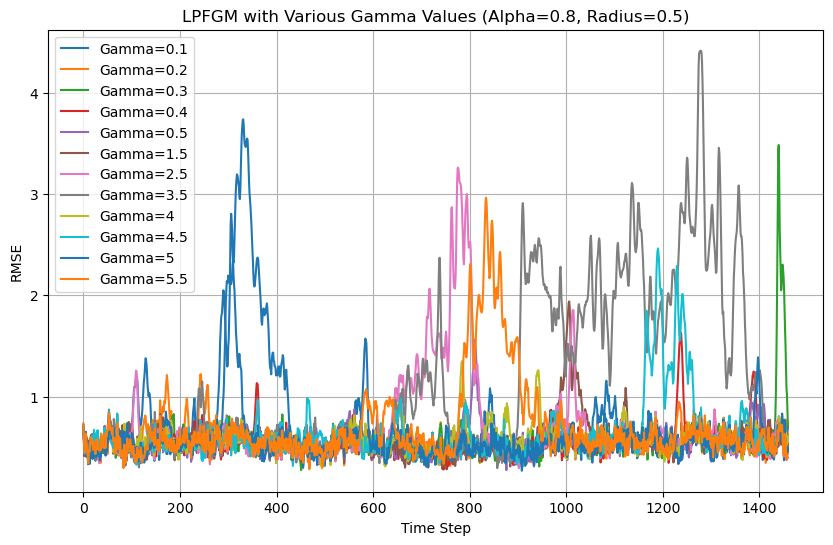

Gamma=0.1, Average RMSE=0.7378
Gamma=0.2, Average RMSE=0.5704
Gamma=0.3, Average RMSE=0.5642
Gamma=0.4, Average RMSE=0.5598
Gamma=0.5, Average RMSE=0.5632
Gamma=1.5, Average RMSE=0.5769
Gamma=2.5, Average RMSE=0.7129
Gamma=3.5, Average RMSE=1.1637
Gamma=4, Average RMSE=0.5725
Gamma=4.5, Average RMSE=0.6404
Gamma=5, Average RMSE=0.5884
Gamma=5.5, Average RMSE=0.6976


In [20]:
# Compare LPFGM performance with different gamma parameters (fixed alpha and beta, radius)
fixed_radius = 0.5
alpha = 0.8
beta = 0
gamma_list = [0.1,0.2,0.3,0.4,0.5, 1.5, 2.5, 3.5, 4, 4.5 ,5, 5.5 ]  # Different gamma values to test
ensemble_size = 50
rmse_results_gamma = []

H = np.eye(N)
R = np.eye(N)
Q = np.eye(N) * 0

print(f"Testing LPFGM with different gamma values (alpha={alpha}, radius={fixed_radius})...")

for gamma in gamma_list:
    print(f"Running LPFGM with gamma={gamma}")
    
    # Reset ensemble and weights
    P = np.eye(N) * 1
    x = np.random.multivariate_normal(stored_data[0,:], P, size=ensemble_size).T
    weights = None
    
    filtered_data = np.zeros_like(obs_data)
    rmse_values = np.zeros(obs_data.shape[0])
    
    for t in range(obs_data.shape[0]):
        x, weights = f.local_particle_filter_gaussian_mixture(
            x, H, R, obs_data[t], Q, 
            weights=weights,
            loc_radius=fixed_radius,
            model=f.rk4_step,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_samples=10,
            Neff_threshold=ensemble_size/2,
            tau=0.1
        )
        filtered_data[t] = np.mean(x, axis=1)
        rmse_values[t] = f.rmse(stored_data[t], filtered_data[t])
    
    rmse_results_gamma.append(rmse_values)

# Plot RMSE vs time for different gamma values
plt.figure(figsize=(10, 6))
for i, gamma in enumerate(gamma_list):
    plt.plot(rmse_results_gamma[i], label=f"Gamma={gamma}")
plt.xlabel("Time Step")
plt.ylabel("RMSE")
plt.title(f"LPFGM with Various Gamma Values (Alpha={alpha}, Radius={fixed_radius})")
plt.legend()
plt.grid(True)
plt.show()

# Compare average RMSE after spin-up
spinup_steps = 50
avg_rmse_by_gamma = [np.mean(rmse[spinup_steps:]) for rmse in rmse_results_gamma]
for gamma, val in zip(gamma_list, avg_rmse_by_gamma):
    print(f"Gamma={gamma}, Average RMSE={val:.4f}")



/Users/nsakai/Desktop/DA_course/Functions.py:439: RuntimeWarning: invalid value encountered in divide
  posterior_weights /= np.sum(posterior_weights)  # normalize
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: overflow encountered in scalar multiply
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: overflow encountered in scalar multiply
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: overflow encountered in scalar multiply
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: overflow encountered in scalar multiply
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: 

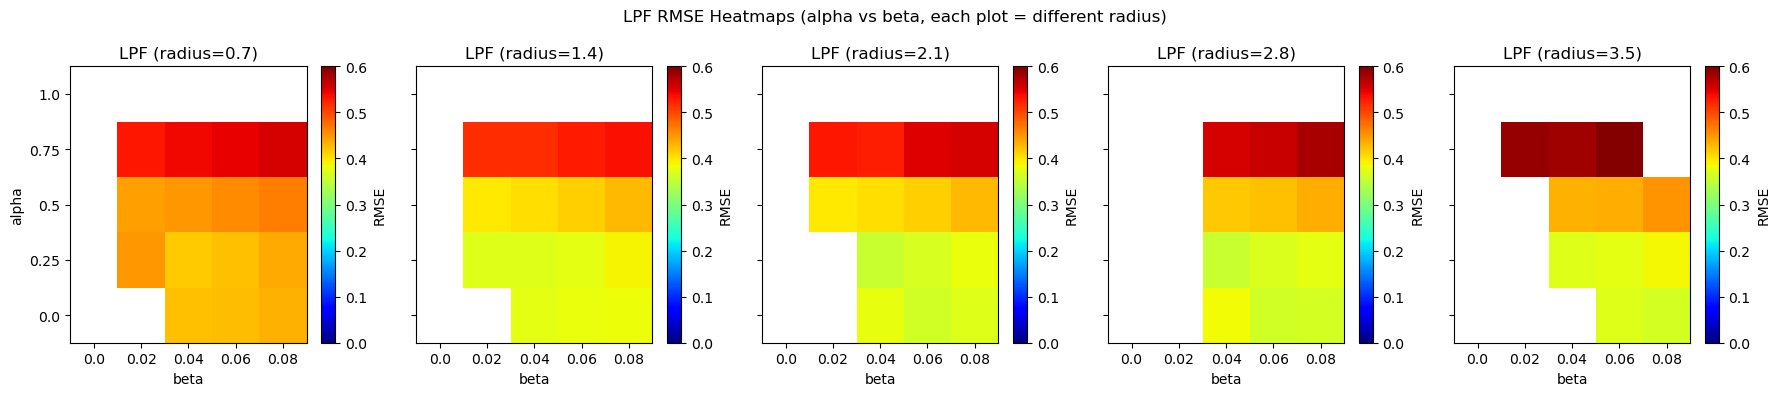

In [ ]:
# -------------------------------------------
# LPF Parameter Sweep: alpha, beta, radius ,ensemble_size = 50
# -------------------------------------------

alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.02, 0.04, 0.06, 0.08]
radius_list = [0.7 ,1.4, 2.1, 2.8 , 3.5]

ensemble_size = 50
steps_to_assimilate = obs_data.shape[0]
spinup_steps = 50  # Steps to disregard before averaging RMSE

lpf_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPF with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta,
                        n_samples=10, Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpf_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpf_results[i, j, k] = np.nan


# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpf_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPF (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPF RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


In [27]:
#print the optimal parameters
#remove NaN values from results
lpf_results = np.nan_to_num(lpf_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpf_results, axis=None), lpf_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:",lpf_results[optimal_params])

Optimal parameters: alpha=0.25, beta=0.04, radius=2.8
Minimum RMSE: 0.35497686267758205


/Users/nsakai/Desktop/DA_course/Functions.py:439: RuntimeWarning: invalid value encountered in divide
  posterior_weights /= np.sum(posterior_weights)  # normalize
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: overflow encountered in scalar multiply
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: overflow encountered in scalar multiply
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: overflow encountered in scalar multiply
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: overflow encountered in scalar multiply
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: 

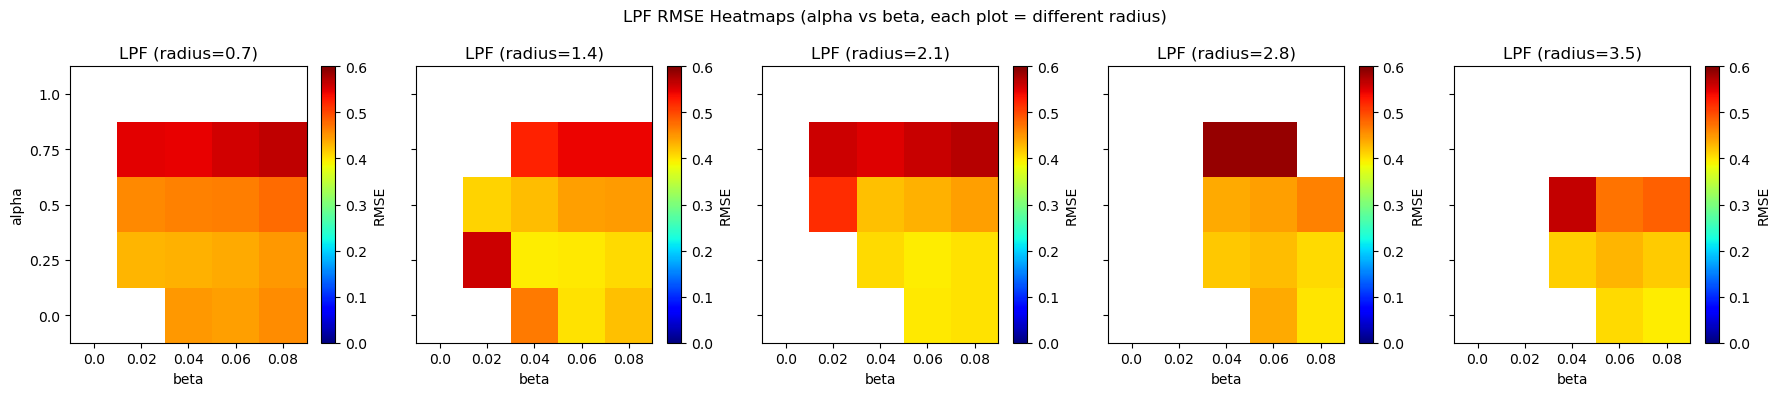

In [12]:
# -------------------------------------------
# LPF Parameter Sweep: alpha, beta, radius,ensemble_size = 30
# -------------------------------------------

alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.02, 0.04, 0.06, 0.08]
radius_list = [0.7 ,1.4, 2.1, 2.8 , 3.5]

ensemble_size = 30
steps_to_assimilate = obs_data.shape[0]
spinup_steps = 50  # Steps to disregard before averaging RMSE

lpf_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPF with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta,
                        n_samples=10, Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpf_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpf_results[i, j, k] = np.nan


# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpf_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPF (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPF RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


In [13]:
#print the optimal parameters
#remove NaN values from results
lpf_results = np.nan_to_num(lpf_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpf_results, axis=None), lpf_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:",lpf_results[optimal_params])

Optimal parameters: alpha=0.25, beta=0.06, radius=2.1
Minimum RMSE: 0.3938520878149098


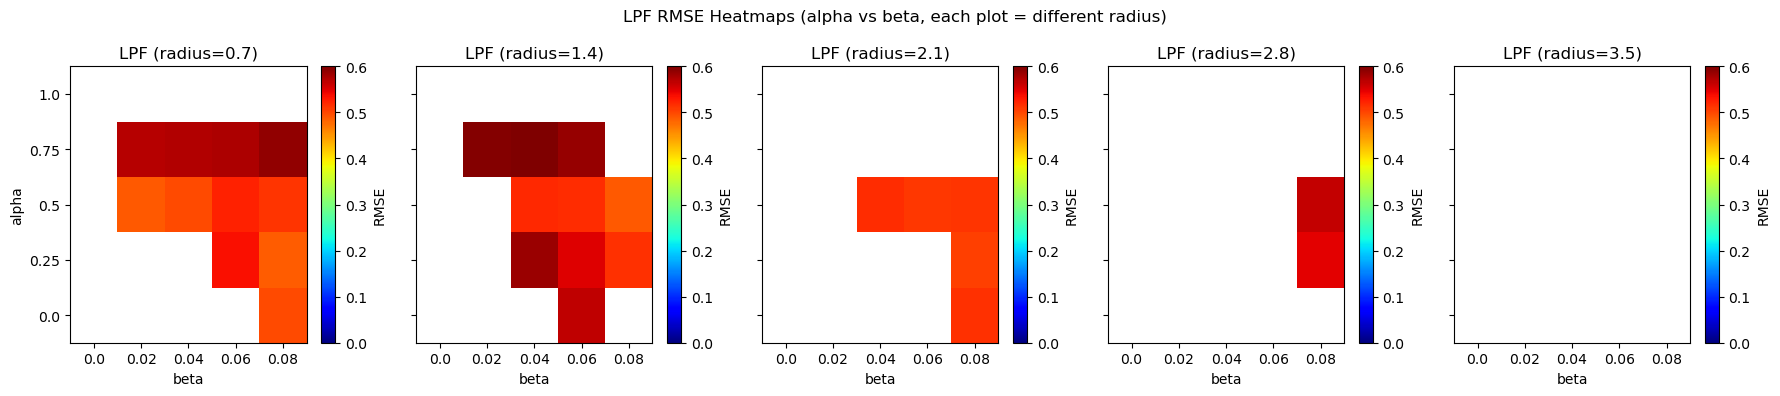

In [ ]:
# -------------------------------------------
# LPF Parameter Sweep: alpha, beta, radius,ensemble_size = 10
# -------------------------------------------

alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.02, 0.04, 0.06, 0.08]
radius_list = [0.7 ,1.4, 2.1, 2.8 , 3.5]

ensemble_size = 10
steps_to_assimilate = obs_data.shape[0]
spinup_steps = 50  # Steps to disregard before averaging RMSE

lpf_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPF with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta,
                        n_samples=10, Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpf_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpf_results[i, j, k] = np.nan


# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpf_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPF (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPF RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


In [8]:
#print the optimal parameters
#remove NaN values from results
lpf_results = np.nan_to_num(lpf_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpf_results, axis=None), lpf_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:",lpf_results[optimal_params])

Optimal parameters: alpha=0.25, beta=0.08, radius=0.7
Minimum RMSE: 0.4870215521271011


/Users/nsakai/Desktop/DA_course/Functions.py:613: RuntimeWarning: invalid value encountered in divide
  posterior_weights = likelihood / np.sum(likelihood)
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: overflow encountered in scalar multiply
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: overflow encountered in scalar multiply
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: overflow encountered in scalar multiply
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: overflow encountered in scalar multiply
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:542: RuntimeWarning: invalid value encountered in subtract
  Z = ens_forecast - x_bar_f[:, None]      # shape (Nx, m)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_m

Skipping alpha=1.0, beta=0.0, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.0, radius=2.8. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:585: RuntimeWarning: overflow encountered in matmul
  P_tilde_inv = np.eye(m) * ((m-1) / gamma) + HZ.T @ R_loc_inv @ HZ


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.01, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.01, radius=2.8. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:28: RuntimeWarning: invalid value encountered in add
  return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


Skipping alpha=1.0, beta=0.02, radius=2.1. Error: SVD did not converge


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Skipping alpha=1.0, beta=0.02, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.03, radius=2.1. Error: SVD did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.03, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.04, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.04, radius=2.8. Error: SVD did not converge


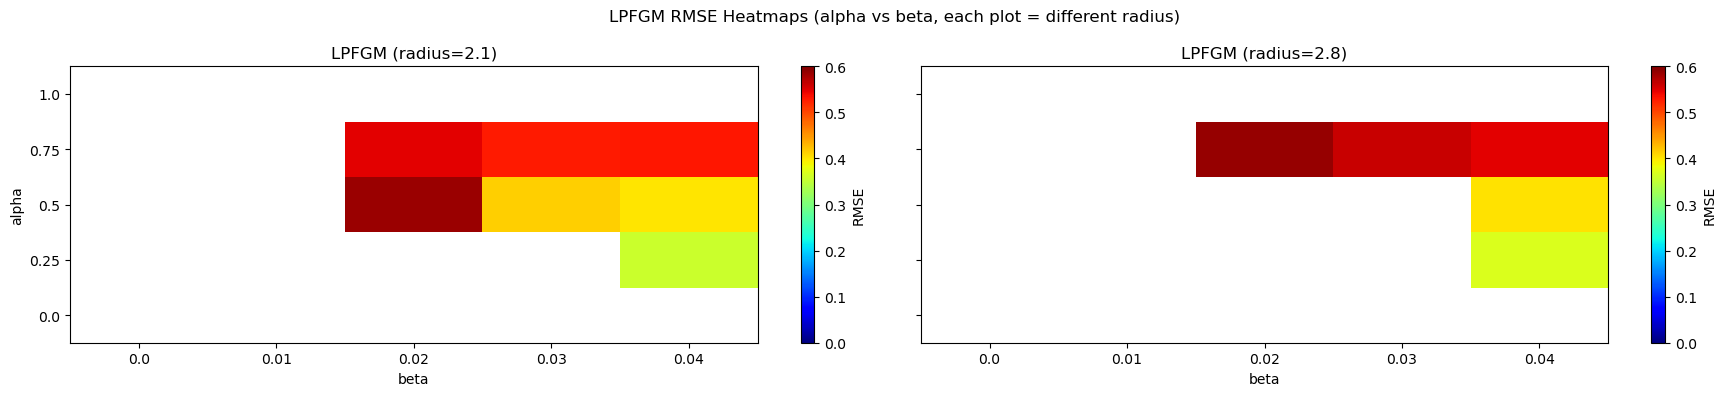

In [28]:
# --------------------------------------------
# LPFGM Parameter Sweep: alpha, gamma, radius
# --------------------------------------------
alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.01, 0.02, 0.03, 0.04]
radius_list = [2.1,2.8]
gamma = 4
ensemble_size = 50

lpfgm_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPFGM with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter_gaussian_mixture(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta, gamma=gamma, n_samples=10,
                        Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpfgm_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpfgm_results[i, j, k] = np.nan



# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpfgm_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPFGM (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPFGM RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()

In [29]:
#print the best parameters
#print the optimal parameters
#remove NaN values from results
lpfgm_results = np.nan_to_num(lpfgm_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpfgm_results, axis=None), lpfgm_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:", lpfgm_results[optimal_params])

Optimal parameters: alpha=0.25, beta=0.04, radius=2.1
Minimum RMSE: 0.35842055732281786


/Users/nsakai/Desktop/DA_course/Functions.py:613: RuntimeWarning: invalid value encountered in divide
  posterior_weights = likelihood / np.sum(likelihood)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/nsakai/Desktop/DA_course/Functions.py:585: RuntimeWarning: overflow encountered in matmul
  P_tilde_inv = np.eye(m) * ((m-1) / gamma) + HZ.T @ R_loc_inv @ HZ


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.0, radius=2.1. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: overflow encountered in scalar multiply
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:542: RuntimeWarning: invalid value encountered in subtract
  Z = ens_forecast - x_bar_f[:, None]      # shape (Nx, m)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Skipping alpha=1.0, beta=0.0, radius=2.8. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: overflow encountered in scalar multiply
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: overflow encountered in scalar multiply
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: overflow encountered in scalar multiply
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeW

Skipping alpha=1.0, beta=0.01, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.01, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.02, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.02, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.03, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.03, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.04, radius=2.1. Error: SVD did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.04, radius=2.8. Error: SVD did not converge


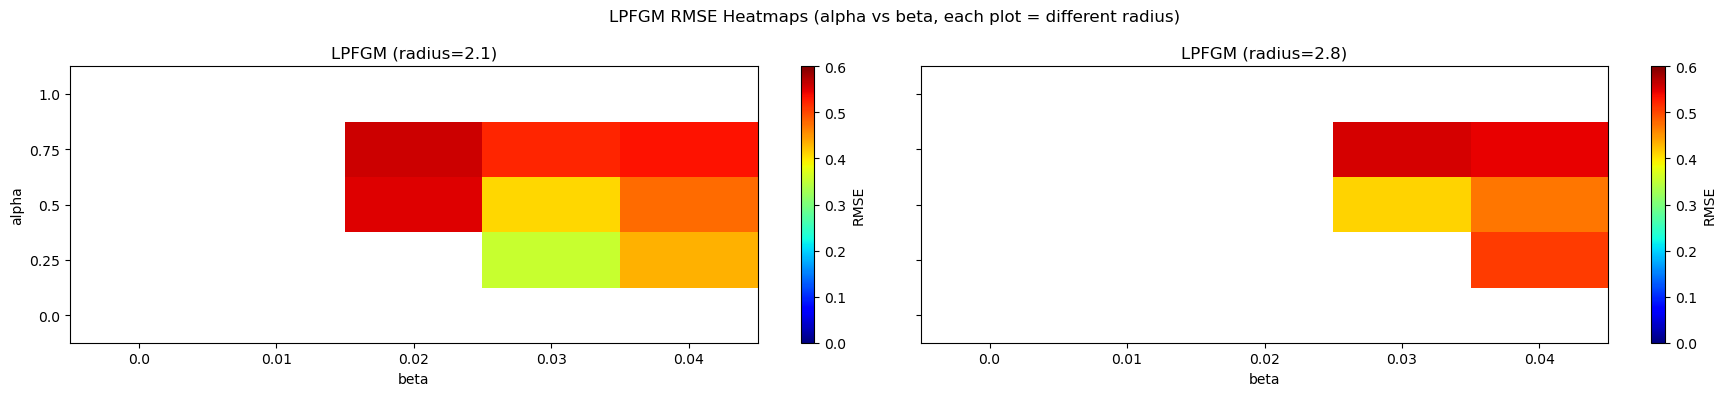

Optimal parameters: alpha=0.25, beta=0.03, radius=2.1
Minimum RMSE: 0.35466092262658416


In [ ]:

# --------------------------------------------
# LPFGM Parameter Sweep: alpha, gamma=0.5, radius
# --------------------------------------------
alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.01, 0.02, 0.03, 0.04]
radius_list = [2.1,2.8]
gamma = 0.5
ensemble_size = 50

lpfgm_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPFGM with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter_gaussian_mixture(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta, gamma=gamma, n_samples=10,
                        Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpfgm_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpfgm_results[i, j, k] = np.nan



# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpfgm_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPFGM (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPFGM RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


#print the best parameters
#print the optimal parameters
#remove NaN values from results
lpfgm_results = np.nan_to_num(lpfgm_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpfgm_results, axis=None), lpfgm_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:", lpfgm_results[optimal_params])

/Users/nsakai/Desktop/DA_course/Functions.py:613: RuntimeWarning: invalid value encountered in divide
  posterior_weights = likelihood / np.sum(likelihood)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsakai/Desktop/DA_course/Functions.py:585: RuntimeWarning: overflow encountered in matmul
  P_tilde_inv = np.eye(m) * ((m-1) / gamma) + HZ.T @ R_loc_inv @ HZ


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.0, radius=2.1. Error: SVD did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.0, radius=2.8. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: overflow encountered in scalar multiply
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: overflow encountered in scalar multiply
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: overflow encountered in scalar multiply
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:28: RuntimeWarning: invalid value encountered in add
  return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
/Users/nsakai/Desktop/DA_course/Functions.py:542: RuntimeWarning: invalid

Skipping alpha=1.0, beta=0.01, radius=2.1. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F
/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Skipping alpha=1.0, beta=0.01, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.02, radius=2.1. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: overflow encountered in scalar multiply
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F


Skipping alpha=1.0, beta=0.02, radius=2.8. Error: SVD did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.03, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.03, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.04, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.04, radius=2.8. Error: SVD did not converge


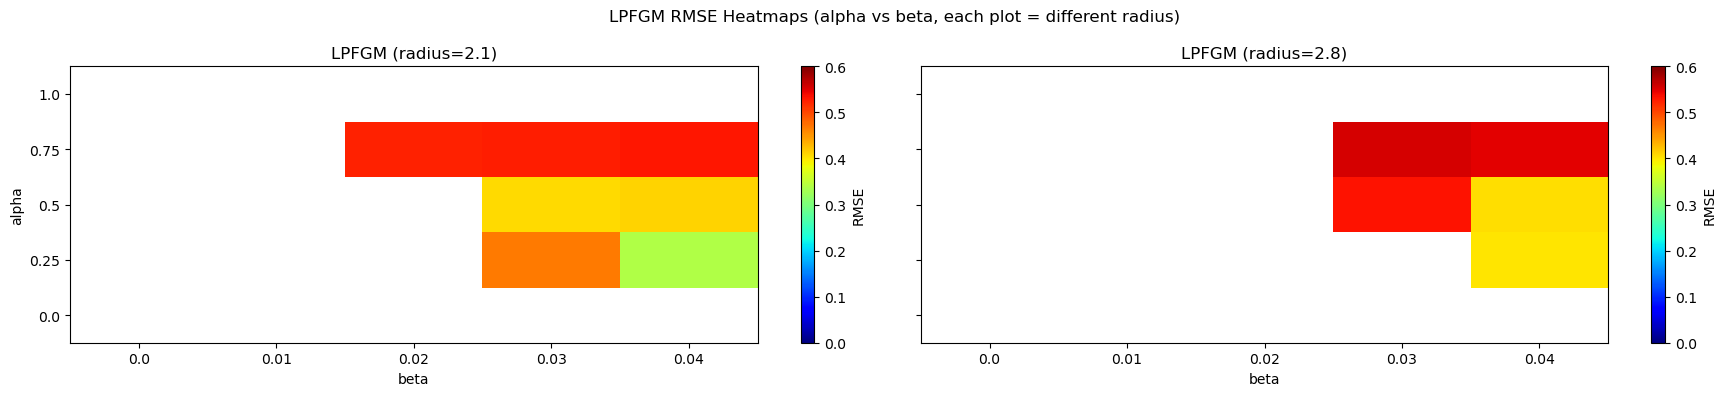

Optimal parameters: alpha=0.25, beta=0.04, radius=2.1
Minimum RMSE: 0.3376696627259656


In [ ]:
# --------------------------------------------
# LPFGM Parameter Sweep: alpha, gamma=1.5, radius
# --------------------------------------------
alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.01, 0.02, 0.03, 0.04]
radius_list = [2.1,2.8]
gamma = 1.5
ensemble_size = 50

lpfgm_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPFGM with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter_gaussian_mixture(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta, gamma=gamma, n_samples=10,
                        Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpfgm_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpfgm_results[i, j, k] = np.nan



# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpfgm_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPFGM (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPFGM RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


#print the best parameters
#print the optimal parameters
#remove NaN values from results
lpfgm_results = np.nan_to_num(lpfgm_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpfgm_results, axis=None), lpfgm_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:", lpfgm_results[optimal_params])

/Users/nsakai/Desktop/DA_course/Functions.py:613: RuntimeWarning: invalid value encountered in divide
  posterior_weights = likelihood / np.sum(likelihood)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/nsakai/Desktop/DA_course/Functions.py:585: RuntimeWarning: overflow encountered in matmul
  P_tilde_inv = np.eye(m) * ((m-1) / gamma) + HZ.T @ R_loc_inv @ HZ


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.0, radius=2.1. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: overflow encountered in scalar multiply
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  d[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
/Users/nsakai/Desktop/DA_course/Functions.py:28: RuntimeWarning: invalid value encountered in add
  return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
/Users/nsakai/Desktop/DA_course/Functions.py:542: RuntimeWarning: invalid value encountered in subtract
  Z = ens_forecast - x_bar_f[:, None]      # shape (Nx, m)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Skipping alpha=1.0, beta=0.0, radius=2.8. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:15: RuntimeWarning: overflow encountered in scalar multiply
  d[0] = (x[1] - x[N - 2]) * x[N - 1] - x[0] + F
/Users/nsakai/Desktop/DA_course/Functions.py:16: RuntimeWarning: overflow encountered in scalar multiply
  d[1] = (x[2] - x[N - 1]) * x[0] - x[1] + F


Skipping alpha=1.0, beta=0.01, radius=2.1. Error: SVD did not converge


/Users/nsakai/Desktop/DA_course/Functions.py:17: RuntimeWarning: overflow encountered in scalar multiply
  d[N - 1] = (x[0] - x[N - 3]) * x[N - 2] - x[N - 1] + F


Skipping alpha=1.0, beta=0.01, radius=2.8. Error: SVD did not converge
Skipping alpha=1.0, beta=0.02, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.02, radius=2.8. Error: SVD did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.03, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.03, radius=2.8. Error: SVD did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping alpha=1.0, beta=0.04, radius=2.1. Error: SVD did not converge
Skipping alpha=1.0, beta=0.04, radius=2.8. Error: SVD did not converge


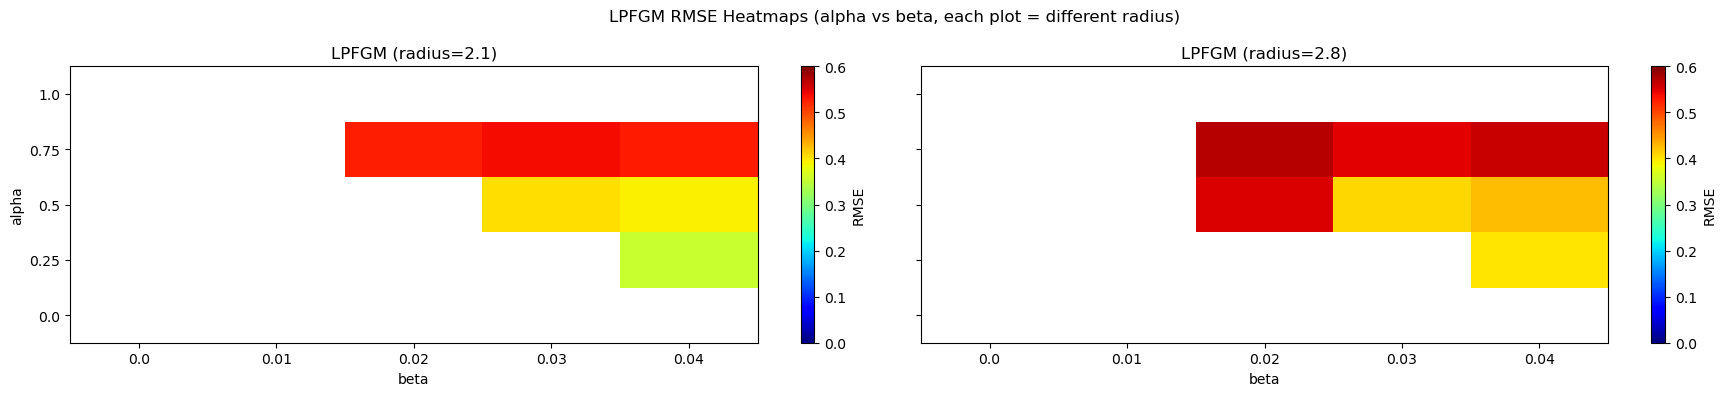

Optimal parameters: alpha=0.25, beta=0.04, radius=2.1
Minimum RMSE: 0.355746669460944


In [ ]:
# --------------------------------------------
# LPFGM Parameter Sweep: alpha, gamma=2.5, radius
# --------------------------------------------
alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
beta_list = [0.0, 0.01, 0.02, 0.03, 0.04]
radius_list = [2.1,2.8]
gamma = 2.5
ensemble_size = 50

lpfgm_results = np.zeros((len(alpha_list), len(beta_list), len(radius_list)))

for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        for k, radius in enumerate(radius_list):
            # Reset ensemble
            P = np.eye(N) * 1.0
            x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
            weights = None
            rmse_vals = np.zeros(steps_to_assimilate)

            try:
                # Run LPFGM with these parameters
                for t in range(steps_to_assimilate):
                    x, weights = f.local_particle_filter_gaussian_mixture(
                        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
                        weights=weights, loc_radius=radius, model=f.rk4_step,
                        alpha=alpha, beta=beta, gamma=gamma, n_samples=10,
                        Neff_threshold=ensemble_size/2, tau=0.1
                    )
                    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))
                # Store mean RMSE after spinup
                lpfgm_results[i, j, k] = np.mean(rmse_vals[spinup_steps:])
            except Exception as e:
                print(f"Skipping alpha={alpha}, beta={beta}, radius={radius}. Error: {e}")
                lpfgm_results[i, j, k] = np.nan



# 2D heatmaps: for each radius, show alpha vs beta
fig, axes = plt.subplots(1, len(radius_list), figsize=(18, 4), sharey=True)

# Create custom colormap with white for values > 1
cmap = plt.cm.jet.copy()
cmap.set_over('white')

for idx, radius in enumerate(radius_list):
    ax = axes[idx]
    data_2d = lpfgm_results[:, :, idx]
    
    # Plot with values > 1 appearing as white
    c = ax.imshow(data_2d, origin='lower', cmap=cmap,
                  extent=[0, len(beta_list), 0, len(alpha_list)],
                  aspect='auto', vmin=0, vmax=0.6)
    
    ax.set_title(f"LPFGM (radius={radius})")
    ax.set_xticks(np.arange(len(beta_list)) + 0.5)
    ax.set_yticks(np.arange(len(alpha_list)) + 0.5)
    ax.set_xticklabels(beta_list)
    ax.set_yticklabels(alpha_list)
    ax.set_xlabel("beta")
    if idx == 0:
        ax.set_ylabel("alpha")
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSE')

plt.suptitle("LPFGM RMSE Heatmaps (alpha vs beta, each plot = different radius)")
plt.tight_layout()
plt.show()


#print the best parameters
#print the optimal parameters
#remove NaN values from results
lpfgm_results = np.nan_to_num(lpfgm_results, nan=np.inf)
optimal_params = np.unravel_index(np.argmin(lpfgm_results, axis=None), lpfgm_results.shape)
optimal_alpha = alpha_list[optimal_params[0]]
optimal_beta = beta_list[optimal_params[1]]
optimal_radius = radius_list[optimal_params[2]]
print(f"Optimal parameters: alpha={optimal_alpha}, beta={optimal_beta}, radius={optimal_radius}")
print("Minimum RMSE:", lpfgm_results[optimal_params])

In [23]:
#lpfgm sinle run with Optimal parameters with effective sample size: alpha=0.25, beta=0.04, gamma=1.5, radius=2.1

# Reset ensemble
ensemble_size = 50
steps_to_assimilate = obs_data.shape[0]
spinup_steps = 50  # Steps to disregard before averaging RMSE

P = np.eye(N) * 1.0
x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
weights = None
rmse_vals = np.zeros(steps_to_assimilate)   

# Run LPFGM with optimal parameters
for t in range(steps_to_assimilate):
    x, weights = f.local_particle_filter_gaussian_mixture(
        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
        weights=weights, loc_radius=2.1, model=f.rk4_step,
        alpha=0.25, beta=0.04, gamma=1.5, n_samples=10,
        Neff_threshold=ensemble_size/2, tau=0.5
    )
    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))   

# print final RMSE
final_rmse = np.mean(rmse_vals[spinup_steps:])
print("Final RMSE after LPFGM with effective sample size",final_rmse)

Final RMSE after LPFGM with effective sample size 0.43285693144469256


In [ ]:
#lpfgm sinle run with Optimal parameters without effective sample size: alpha=0.25, beta=0.04, gamma=1.5, radius=2.1

# Reset ensemble
ensemble_size = 50
steps_to_assimilate = obs_data.shape[0]
spinup_steps = 50  # Steps to disregard before averaging RMSE

P = np.eye(N) * 1.0
x = np.random.multivariate_normal(stored_data[0], P, size=ensemble_size).T
weights = None
rmse_vals = np.zeros(steps_to_assimilate)   

# Run LPFGM with optimal parameters
for t in range(steps_to_assimilate):
    x, weights = f.local_particle_filter_gaussian_mixture(
        x, H=np.eye(N), R=np.eye(N), y=obs_data[t], Q=np.eye(N)*0,
        weights=weights, loc_radius=2.1, model=f.rk4_step,
        alpha=0.25, beta=0.04, gamma=1.5, n_samples=10,
        Neff_threshold=None, tau=0.1
    )
    rmse_vals[t] = f.rmse(stored_data[t], np.mean(x, axis=1))   

# print final RMSE
final_rmse = np.mean(rmse_vals[spinup_steps:])
print("Final RMSE after LPFGM with effective sample size",final_rmse)

Final RMSE after LPFGM with effective sample size 0.3420025364016599
